<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-09-16 13:29:13--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-09-16 13:29:13 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Let's plot some columns to understand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



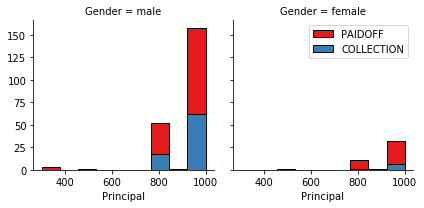

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Size of principal appears to be a factor, with larger principals (>= 800) having higher level non-repayment, particularly for males.

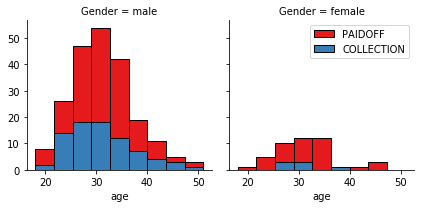

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Age appears to be a factor in non-payment. Ages between 20 and 40 are less likely to pay on time, particularly for males

# Pre-processing:  Feature selection/extraction

### Let's look at the day of the week people get the loan 

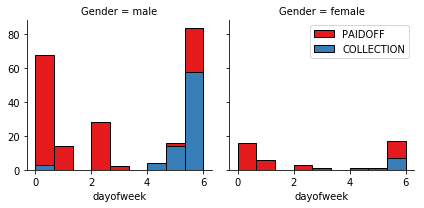

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Let's look at due month as a factor

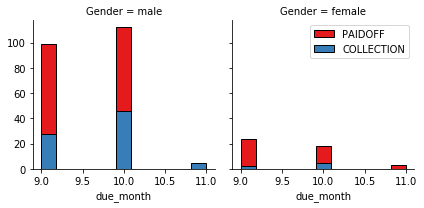

In [12]:
df['due_month'] = df['due_date'].dt.month
bins = np.linspace(df.due_month.min(), df.due_month.max(), 12)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'due_month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Given lack of spread of months in the data, it's hard to draw conclusions here I think.

## Let's look at the loan terms as a factor

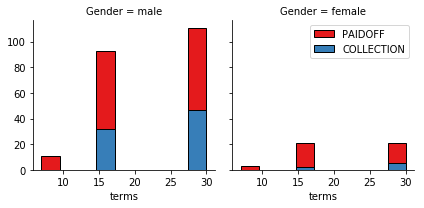

In [13]:
bins = np.linspace(df.terms.min(), df.terms.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'terms', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that loans with 7 day terms are generally paid off, and that paid off loans decrease with length of terms

## Convert Categorical features to numerical values

Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay their loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,due_month
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,10
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,10
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,9
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,10
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,10


## One Hot Encoding  
#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend', 'due_month']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,due_month,Bechalor,High School or Below,college
0,1000,30,45,0,0,10,0,1,0
1,1000,30,33,1,0,10,1,0,0
2,1000,15,27,0,0,9,0,0,1
3,1000,30,28,1,1,10,0,0,1
4,1000,30,29,0,1,10,0,0,1


### Feature selection

Lets define feature sets, X:

In [19]:
X = Feature
X[0:6]

,Principal,terms,age,Gender,weekend,due_month,Bechalor,High School or Below,college
0,1000,30,45,0,0,10,0,1,0
1,1000,30,33,1,0,10,1,0,0
2,1000,15,27,0,0,9,0,0,1
3,1000,30,28,1,1,10,0,0,1
4,1000,30,29,0,1,10,0,0,1
5,1000,30,36,0,1,10,0,0,1


In [20]:
Feature.describe()

,Principal,terms,age,Gender,weekend,due_month,Bechalor,High School or Below,college
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,943.641618,22.653179,30.939306,0.150289,0.592486,9.592486,0.127168,0.436416,0.430636
std,109.425530,7.991006,6.039418,0.357872,0.492084,0.558311,0.333643,0.496659,0.495882
min,300.000000,7.000000,18.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000
25%,900.000000,15.000000,27.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000
50%,1000.000000,30.000000,30.000000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000
75%,1000.000000,30.000000,35.000000,0.000000,1.000000,10.000000,0.000000,1.000000,1.000000
max,1000.000000,30.000000,51.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000


What are our labels?

In [21]:
df['loan_status'].values[0:6]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Need to convert loan_status (the target catagory) to binary: PAIDOFF=0, COLLECTION=1

In [22]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,due_month
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,10
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,10
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,9
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,10
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,10


In [23]:
y = df['loan_status'].values
y[0:6]

array([0, 0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [24]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:6]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
         0.73096253, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         0.73096253,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -1.06274694, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.73096253, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.73096253, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769,  0.8391575 , -0.42056004,  0.82934003,
         0.73096253, -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Split train and test data

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

max_k = 15
jaccard_acc = np.zeros((max_k))
f1_acc = np.zeros((max_k))

for n in range(1, max_k+1):
    # train, predict and score accuracy of model for each k using the train data
    knn_classifier = KNeighborsClassifier(n_neighbors = n)
    knn_classifier.fit(X_train,y_train)
    prediction = knn_classifier.predict(X_test)
    jaccard_acc[n-1] = metrics.jaccard_similarity_score(y_test, prediction)
    f1_acc[n-1] = metrics.f1_score(y_test, prediction)

print("jaccard:  ", jaccard_acc)
print("f-1 score: ", f1_acc)


jaccard:   [0.75       0.76923077 0.72115385 0.75       0.71153846 0.74038462
 0.75       0.74038462 0.74038462 0.75961538 0.69230769 0.73076923
 0.73076923 0.74038462 0.69230769]
f-1 score:  [0.48       0.29411765 0.43137255 0.31578947 0.4        0.34146341
 0.40909091 0.34146341 0.37209302 0.32432432 0.30434783 0.22222222
 0.22222222 0.18181818 0.2       ]


### Plot the accuracy of each K

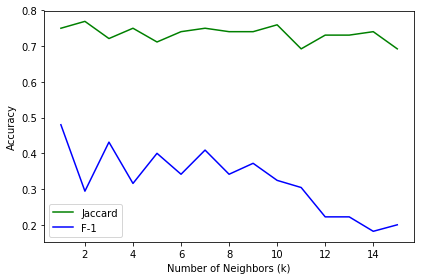

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

plt.plot(range(1, max_k+1),jaccard_acc,'green')
plt.plot(range(1, max_k+1),f1_acc,'blue')
plt.legend(('Jaccard', 'F-1'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()

In [30]:
# the optimal number of nearest neighbors is k
best_k = jaccard_acc.argmax() + 1

print("The best K was", best_k, "with jaccard score of", jaccard_acc.max())
print("(Following the example in course workshop, will not look at the f-1 score of", f1_acc[jaccard_acc.argmax()], "and pick best K based on jaccard index only.)")

The best K was 2 with jaccard score of 0.7692307692307693
(Following the example in course workshop, will not look at the f-1 score of 0.2941176470588235 and pick best K based on jaccard index only.)


# Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

classifier = DecisionTreeClassifier(criterion="entropy", max_depth = 30)
classifier.fit(X_train,y_train)
prediction = classifier.predict(X_test)

In [32]:
jaccard_accuracy = metrics.accuracy_score(y_test, prediction)
print("Jaccard:  ", jaccard_accuracy)

Jaccard:   0.7403846153846154


In [33]:
f1_accuracy = metrics.f1_score(y_test, prediction)
print("F-1:      ", f1_accuracy)

F-1:       0.425531914893617


# Support Vector Machine

In [34]:
from sklearn import svm

def svm_bakeoff(kernel_type):
    svm_classifier = svm.SVC(kernel=kernel_type, gamma='auto')
    svm_classifier.fit(X_train, y_train)
    prediction = svm_classifier.predict(X_test)
    jaccard_accuracy = metrics.accuracy_score(y_test, prediction)
    f1_accuracy = metrics.f1_score(y_test, prediction)
    print("> Accuracy for SVM classifier with kernel type", kernel_type)
    print("   Jaccard: ", jaccard_accuracy)
    print("   F1     : ", f1_accuracy)
    return jaccard_accuracy

In [35]:
jaccard_accuracy = 0
best_svm_kernel_type = ''
for t in ['rbf', 'linear', 'poly', 'sigmoid']:
    acc = svm_bakeoff(t)
    if (acc > jaccard_accuracy):
        jaccard_accuracy = acc
        best_svm_kernel_type = t

print("Jaccard accuracy for SVM classifier:", jaccard_accuracy, "was best accuracy using kernel type", best_svm_kernel_type)

> Accuracy for SVM classifier with kernel type rbf
   Jaccard:  0.75
   F1     :  0.07142857142857142
> Accuracy for SVM classifier with kernel type linear
   Jaccard:  0.7403846153846154
   F1     :  0.0
> Accuracy for SVM classifier with kernel type poly
   Jaccard:  0.7692307692307693
   F1     :  0.25
> Accuracy for SVM classifier with kernel type sigmoid
   Jaccard:  0.7211538461538461
   F1     :  0.17142857142857143
Jaccard accuracy for SVM classifier: 0.7692307692307693 was best accuracy using kernel type poly


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
f1_accuracy = metrics.f1_score(y_test, prediction)
print("F-1:      ", f1_accuracy)

F-1:       0.425531914893617


# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=100, solver='liblinear')
classifier.fit(X_train,y_train)
prediction = classifier.predict(X_test)

In [38]:
jaccard_accuracy = metrics.accuracy_score(y_test, prediction)
print("Accuracy for logistic regression classifier")
print("Jaccard: ", jaccard_accuracy)

Accuracy for logistic regression classifier
Jaccard:  0.7019230769230769


In [39]:
f1_accuracy = metrics.f1_score(y_test, prediction)
print("F-1:      ", f1_accuracy)

F-1:       0.24390243902439024


In [40]:
log_loss = metrics.log_loss(y_test, prediction)
print("LogLoss:      ", log_loss)

LogLoss:       10.295281390568297


# Model Evaluation using Test set

In [41]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [42]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-09-16 13:33:37--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-09-16 13:33:37 (288 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [43]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Check shape of data is as expected

In [44]:
test_df.shape

(54, 10)

## Pre-processing

Apply all the pre-processing steps to the test data that we applied to the train data

In [45]:
# convert date fields to datetime
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])

# extract day-of-week (of 'effective_date') as a field
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

# reduce day-of-week to binary: weekend day or not
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# extract due_month (of 'due_date') as a field
test_df['due_month'] = test_df['due_date'].dt.month

# binarize 'gender'
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# extract desired feature set from data
Feature = test_df[['Principal','terms','age','Gender','weekend', 'due_month']]

# binarize the multi-valued categorical field education
Feature = pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

Feature.head()

,Principal,terms,age,Gender,weekend,due_month,Bechalor,High School or Below,college
0,1000,30,50,1,0,10,1,0,0
1,300,7,35,0,0,10,0,0,0
2,1000,30,43,1,0,9,0,1,0
3,1000,30,26,0,1,10,0,0,1
4,800,15,29,0,1,10,1,0,0


## Feature extraction

In [46]:
X = Feature

In [47]:
# scale to align the continuous features
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:6]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -4.12310563,
         0.86135677,  2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054, -4.12310563,
         0.86135677, -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211, -4.12310563,
        -1.16095912, -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.24253563,
         0.86135677, -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.24253563,
         0.86135677,  2.39791576, -0.79772404, -0.86135677],
       [-1.24479571, -0.78854628,  0.19650211, -0.50578054,  0.24253563,
         0.86135677, -0.41702883,  1.25356634, -0.86135677]])

In [48]:
# binarize 'loan_status' target category
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

y = test_df['loan_status'].values
y[0:6]

array([0, 0, 0, 0, 0, 0])

## KNN classifer

In [49]:
# KNN
print("Create KNN classifier using k of", best_k)
classifier = KNeighborsClassifier(n_neighbors = best_k)
classifier.fit(X, y)
prediction = classifier.predict(X)
knn_jaccard = jaccard_similarity_score(y, prediction)
knn_f1 = f1_score(y, prediction)

print("KNN Jaccard ", knn_jaccard)
print("KNN F-1     ", knn_f1)

Create KNN classifier using k of 2
KNN Jaccard  0.8333333333333334
KNN F-1      0.5263157894736842


## Decision Tree classifer

In [50]:
# Decision Tree
classifier = DecisionTreeClassifier(criterion="entropy", max_depth = 30)
classifier.fit(X, y)
prediction = classifier.predict(X)
dt_jaccard = jaccard_similarity_score(y, prediction)
dt_f1 = f1_score(y, prediction)

print("Decision Tree Jaccard ", dt_jaccard)
print("Decision Tree F-1     ", dt_f1)

Decision Tree Jaccard  0.9814814814814815
Decision Tree F-1      0.962962962962963


## Support Vector Machine classifer

In [51]:
# Support Vector Machine
print("Create SVM classifier using kernel type", best_svm_kernel_type)
classifier = svm.SVC(kernel=best_svm_kernel_type, gamma='auto')
classifier.fit(X, y)
prediction = classifier.predict(X)
svm_jaccard = jaccard_similarity_score(y, prediction)
svm_f1 = f1_score(y, prediction)
print("SVM Jaccard ", svm_jaccard)
print("SVM F-1     ", svm_f1)


Create SVM classifier using kernel type poly
SVM Jaccard  0.8148148148148148
SVM F-1      0.4444444444444445


## Logistic Regression classifier

In [52]:
# Logistic Regression
classifier = LogisticRegression(C=100, solver='liblinear')
classifier.fit(X, y)
prediction = classifier.predict(X)
lr_jaccard = jaccard_similarity_score(y, prediction)
lr_f1 = f1_score(y, prediction)
lr_logloss = metrics.log_loss(y, prediction)

print("Logistic Regression Jaccard ", lr_jaccard)
print("Logistic Regression F-1     ", lr_f1)
print("Logistic Regression LogLoss ", lr_logloss)

Logistic Regression Jaccard  0.8148148148148148
Logistic Regression F-1      0.6153846153846153
Logistic Regression LogLoss  6.396128932200512


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [53]:
results = { 'KNN':{}, 'Decision Tree':{}, 'SVM':{}, 'Logistic Regression':{} }
results['KNN']['Jaccard'] = knn_jaccard
results['KNN']['F1-score'] = knn_f1
results['KNN']['LogLoss'] = 'N/A'
results['Decision Tree']['Jaccard'] = dt_jaccard
results['Decision Tree']['F1-score'] = dt_f1
results['Decision Tree']['LogLoss'] = 'N/A'
results['SVM']['Jaccard'] = svm_jaccard
results['SVM']['F1-score'] = svm_f1
results['SVM']['LogLoss'] = 'N/A'
results['Logistic Regression']['Jaccard'] = lr_jaccard
results['Logistic Regression']['F1-score'] = lr_f1
results['Logistic Regression']['LogLoss'] = lr_logloss

results_frame = pd.DataFrame(results).transpose()
results_frame

,F1-score,Jaccard,LogLoss
KNN,0.526316,0.833333,N/A
Decision Tree,0.962963,0.981481,N/A
SVM,0.444444,0.814815,N/A
Logistic Regression,0.615385,0.814815,6.39613


## Conclusion

According to https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions
> *functions ending with `_score` return a value to maximize, the higher the better*

We have used the score functions `jaccard_similarity_score` and `f1_score`, so higher values for these are better.

For Log Loss, lower values (closer to zero) are better.

In this evaluation, **the Decision Tree classifier** has produced the best (highest) Jaccard and F1-score accuracy metrics, so appears to be the best classifier for the dataset.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>